In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 130)
pd.set_option('display.max_columns', 100)

In [2]:
# Import data files

# Column data types, to avoid Pandas trying to parse data type on every column
columns_to_import = ["Case Type","Region","Case Number","Case Name","Status","Date Filed","Date Closed","Reason Closed"
                     ,"City","States & Territories","Employees on charge/petition","Allegations","Participants"]
column_dtypes = {c:"string" for c in columns_to_import}

data_by_year = []
for year in ["pre2000"]+list(range(2000, 2025)):
    cases_that_year = pd.read_csv("data/UnfairLaborPractices/cleaned/"+str(year)+".csv", usecols = columns_to_import, dtype = column_dtypes, parse_dates = ["Date Filed", "Date Closed"], date_format = "%Y-%m-%d")
    # Need to cast Date Closed column to datetime manually, since some entries are <NA>
    cases_that_year["Date Closed"] = pd.to_datetime(cases_that_year["Date Closed"].replace("<NA>", pd.NaT), errors = "coerce")
    cases_that_year["Employees on charge/petition"] = cases_that_year["Employees on charge/petition"].astype('Int64')
    data_by_year += [cases_that_year] 

ULPs = pd.concat(reversed(data_by_year), ignore_index = True)

In [3]:
# Total number of cases = 400340
len(ULPs)

400340

In [4]:
# Index by date filed
ULPs.set_index("Date Filed", inplace=True)

In [5]:
# Check which years have significant number of cases.
# Seems that 2007 onwards is fairly consistently ~20k/year, so should perhaps
# restrict our attention to those years.
ULPs.index.year.value_counts(sort = False)

Date Filed
2024     5407
2023    19408
2022    18113
2021    15178
2020    14733
2019    17809
2018    18891
2017    19145
2016    20933
2015    19915
2014    19385
2013    21143
2012    21032
2011    21335
2010    21824
2009    23015
2008    21125
2007    21686
2006    12794
2005     8818
2004     7114
2003     7962
2002     7496
2001     5122
2000     3882
1999     3235
1998     1634
1997      794
1996      510
1995      314
1994      196
1993      137
1992       93
1991       43
1990       35
1989       32
1988        9
1987        9
1986        9
1985        5
1984        5
1983        3
1982        3
1981        3
1980        1
1978        5
Name: count, dtype: int64

In [6]:
# Get rid of cases prior to 2007. This leaves 340077 cases.
ULPs = ULPs.sort_index().loc["2007":"2024"]
ULPs.shape[0]

340077

In [7]:
# Each case has a number of parties involved, and all of them are stored in the "Participants" column
# in one big messy string. There are three types of parties:
#     1. Charged parties (i.e. the accused)
#     2. Charging parties (i.e. the accuser)
#     3. Involved parties
# Below, we split these types of parties into three new columns "Charged", "Charging", and "Involved"
# Each entry in these columns is a list of parties, each of which is a string

In [8]:
from utilities import get_charged_charging_and_involved
ULPs[["Charged", "Charging", "Involved"]] = pd.DataFrame(ULPs["Participants"].apply(get_charged_charging_and_involved).to_list()).set_index(ULPs.index)

In [9]:
# Now we want to figure out for each case, was it a union or worker who initiated the case, or an employer?
# And against whom? Some cases are union vs union, or individual vs union.
# We are interested in who is making use of the NLRB more, and trends over time.
# This is complicated by the fact that some cases are initiated by multiple parties, and some cases
# are handled just by lawyers, making them hard to parse. Our parsing function does categorize
# a lot of cases as "Other", but leaves us with a decent amount of data regardless.
from utilities import parse_party
from utilities import who_charging_who
from utilities import who_being_charged

ULPs["Who charging who?"] = ULPs[["Charged", "Charging"]].apply(lambda x: who_charging_who(x["Charged"], x["Charging"]), axis = "columns")
ULPs["Who being charged?"] = ULPs["Charged"].apply(who_being_charged)

In [11]:
# It's a bit hard to distill the "who charging who" info.
ULPs.resample("Y")["Who charging who?"].value_counts(normalize=True).sort_index()

Date Filed  Who charging who?           
2007-12-31  Employer charging Union         0.024855
            Individual charging Employer    0.158812
            Individual charging Union       0.197316
            Other                           0.155538
            Other charging Employer         0.073826
            Union charging Employer         0.384949
            Union charging Union            0.004703
2008-12-31  Employer charging Union         0.022627
            Individual charging Employer    0.169515
            Individual charging Union       0.206296
            Other                           0.140260
            Other charging Employer         0.084970
            Union charging Employer         0.372213
            Union charging Union            0.004118
2009-12-31  Employer charging Union         0.017206
            Individual charging Employer    0.170324
            Individual charging Union       0.211036
            Other                           0.124875
     

In [13]:
# The "who being charged" info is easier to digest, and shows a clear trend:
# Since 2007, the number and proportion of cases filed against employers has
# risen steadily, while the number of cases against unions has declined.
# Note that some upticks in filings against employers follow periods of social 
# and labor struggle, e.g. 2011 (Occupy), or 2023 (UAW and entertainment industry strikes).
# This pattern does not hold in 2019, which saw a decline despite the Red for Ed
# movement the year before. We also see a very small downtick in 2017, perhaps
# due to Trump's election the previous year.
#
# Note that the number of cases filed each year has remained fairly steady (actually
# declining slightly with time). 
#
# It may be interesting to break this down in a more nuanced way, e.g. a rolling
# average by date, or by geographic location.
#
ULPs.resample("M")["Who being charged?"].value_counts(normalize=True).sort_index()

Date Filed  Who being charged?
2007-01-31  Employer              0.624101
            Other                 0.151079
            Union                 0.224820
2007-02-28  Employer              0.606472
            Other                 0.144337
                                    ...   
2024-03-31  Other                 0.002608
            Union                 0.180574
2024-04-30  Employer              0.831606
            Other                 0.005181
            Union                 0.163212
Name: proportion, Length: 623, dtype: float64

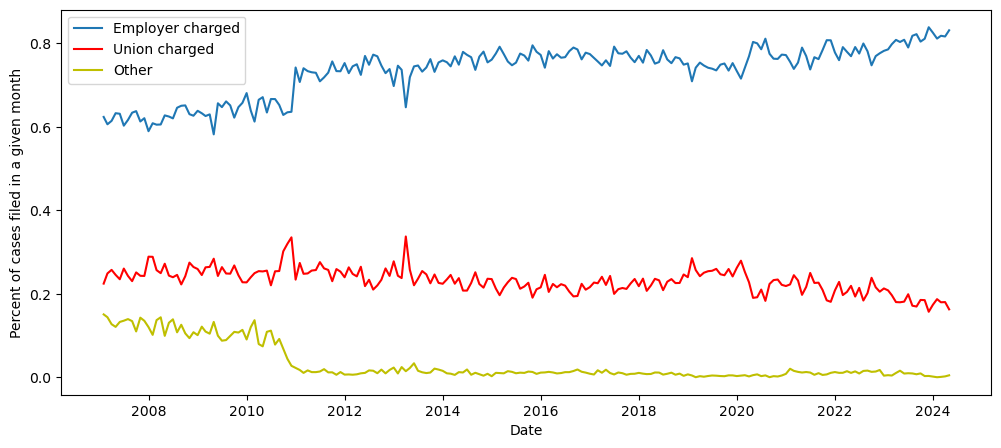

In [60]:
# Plot the proportions of charges against employers and against unions
# on a month-by-month basis
by_month = ULPs.resample("M")["Who being charged?"].value_counts(normalize=True).sort_index().reset_index()
employer_proportions = by_month[by_month["Who being charged?"] == "Employer"]
union_proportions = by_month[by_month["Who being charged?"] == "Union"]
other_proportions = by_month[by_month["Who being charged?"] == "Other"]

plt.rcParams["figure.figsize"] = (12,5)
plt.plot(employer_proportions["Date Filed"], employer_proportions["proportion"], label="Employer charged")
plt.plot(union_proportions["Date Filed"], union_proportions["proportion"], "r", label="Union charged")
plt.plot(other_proportions["Date Filed"], other_proportions["proportion"], "y", label="Other")
plt.ylabel("Percent of cases filed in a given month")
plt.xlabel("Date")
plt.legend()
plt.show()

In [ ]:
# TODO: Analyze whether cases were resolved in favor of unions or no

In [23]:
ULPs["Reason Closed"].value_counts()

Reason Closed
Withdrawal Non-adjusted     111016
Withdrawal Adjusted          86845
Dismissal Non-adjusted       84078
Informal Settlement          26714
Compliance w/BO               4982
Dismissal Adjusted            2572
Non-Compliance w/BO            390
Administrative Closing         230
Partial Compliance w/BO        222
Unit Clarification               4
Certification of Results         1
Name: count, dtype: Int64